# Implementation of a naive triton kernel for hqq-fwd, for axis=1.

The entire operation is: `y = α*magnitude*(x@w.t + x@a.t@b.t)/colnorm`, where `colnorm = |w + b@a|_c,2` is the colwise norm and treated as constant.

We first implement & test subkernels, and later integrate them.

The subkernels are:

    1. dequant zero & scale
    2. unpack w
    3. dequant w
    4. x@w.t
    5. x@a.t@b.t
    6. colnorm
    7. * α, mag, 1/colnorm

**ToDo Umer:**
- Add loading masks in all subkernels?
- Test full kernel with more kinds of inputs (larger, random)

___

**Naming convention:**

Generic:
- bsX  = block size along axis X
- idX  = index along axis X
- nidX = number of chunks along axis X

eg if len(x) = 10, and we divide X into chunks of size 2 (so 10/2=5 chunks), and are selecting the 4rd chunk (ie 6th and 7th value), then bsX=2, idX=4, nidX=5.

Specific:
- b = batch axis
- m = output axis
- n = input axis
- r = lora rank
- gz = group size
- pz = pack size ( = 10, as we pack 10 x 3bit -> 32bit)
- gz2= group size for quanting zero/scale ( = 128 in hqq)
- ~ = shape of (eg A ~ (r,n) means A has shape (r,n))

### Setup

In [1]:
import os, torch, numpy as np, matplotlib.pyplot as plt
from itertools import product
from torch import tensor, cat, int32, float16 as fp16, bfloat16 as bf16, isclose
from IPython.core.debugger import set_trace
from fastcore.foundation import stop
os.environ['TRITON_INTERPRET'] = '1'
import triton, triton.language as tl, triton_util as tu
# abbreviations so I have to type less
const, cdiv, breakpoint_once, print_once, breakpoint_if = tl.constexpr, tu.cdiv, tu.breakpoint_once, tu.print_once, tu.breakpoint_if

torch.set_printoptions(linewidth=200, precision=2, sci_mode=False)
np.set_printoptions(linewidth=200, precision=2) # for triton simulator

In [2]:
dtype = fp16 # can't use bf16 with triton simulator, as numpy doesn't support bf16

def ones(*shape):      return torch.ones(        shape, dtype=dtype, device='cuda')
def zeros(*shape):     return torch.zeros(       shape, dtype=dtype, device='cuda')
def rand(*shape):      return torch.randn(       shape, dtype=dtype, device='cuda')
def rand_3bit(*shape): return torch.randint(size=shape, dtype=dtype, device='cuda', low=0, high=7)

In [3]:
def assert_close(out, expected, do_print=True, atol=None):
    if do_print:
        print('output:',out)
        print('expected:',expected)
    if atol is None: atol = 1e-5
    assert torch.isclose(out, expected,atol=atol).all(), 'Not close 🤔'
    print('Equal ✅')

Many subkernels will compute a block of an overall result. Let's have a function that collects the blocks, so we can compare it to the overall expected output.

In [4]:
def compute_block_wise_and_compare(expected, fn, dims, step_szs, do_print=False, atol=None, do_return=False, do_plot_err=False):
    out = zeros(*dims)
    for ids in product(*[range(cdiv(dim,bs_dim)) for dim, bs_dim in zip(dims,step_szs)]): # iterate over grid over dims; each step has shape cdiv(dim,bs_dim) for each dim
        # compute out_block
        out_block = zeros(*step_szs)
        fn(out_block, *ids)
        # compute where to store out_block in out
        slices_out, slices_block = [], []
        for idx, dim, bs_dim in zip(ids, dims, step_szs):
            # determine location of out_patch in out
            min_id =  idx   *bs_dim
            max_id = (idx+1)*bs_dim
            # don't go out of bounds
            max_id = min(max_id, dim)
            # save location to be used below
            slices_out  .append(slice(min_id, max_id))
            slices_block.append(slice(0, max_id - min_id))
        # store out_block into out
        out[tuple(slices_out)] = out_block[tuple(slices_block)]
    if do_plot_err:
        err = (out-expected).abs().cpu()
        if len(err.shape)==1: err = err[None,:]
        plt.imshow(err, vmin=0, vmax=err.max())
        plt.colorbar()
        plt.show()
    if do_return: return out
    assert_close(out, expected, do_print=do_print, atol=atol)

In [5]:
pz = 10 # pack size is always 10, as we pack 10 3bits -> a 32bit

### Sub-Kernel 1: Load & Dequant zero / scale

In [6]:
@triton.jit
def dequant_zero_or_scale(vals_ptr, zero_ptr, scale_ptr, gz2: const, ng2: const, m: const, bsm: const, idm):
    # load vals_q, which is 2d-shape (gz2,ng2) as 1d-shape (gz2*ng2), this allows loading only the chunk we need
    vals_q = tu.load_1d(vals_ptr, sz=bsm*n//gz, n=idm, max=gz2*ng2) # quanted zero/scale values ; ~ (bsm*n//gz)
    # now, load zero/scale via modulo
    offs = tu.offset_1d(sz=bsm*n//gz, n_prev_chunks=idm) % ng2
    zero = tl.load(zero_ptr + offs, offs < ng2)  # ~ zero  of zero/scale; (bsm*n//gz)
    scale= tl.load(scale_ptr+ offs, offs < ng2)  # ~ scale of zero/scale; (bsm*n//gz)
    # dequant and return
    return (vals_q-zero)*scale  # ~ (bsm*n//gz)

In [7]:
@triton.jit
def test_dequant_zero_or_scale(out_ptr, vals_ptr, zero_ptr, scale_ptr, gz2: const, m: const, n: const, bsm: const, idm):
    ng2 = (m*n)//(gz*gz2)
    vals = dequant_zero_or_scale(vals_ptr, zero_ptr, scale_ptr, gz2, ng2, m, bsm, idm)
    tu.store_full_1d(vals, out_ptr, bsm*n//gz)

In [8]:
m,n     = 8,4
gz,gz2 =  2,8
bsm = 1

assert n%gz==0 and m%gz2==0
ng  = m*n//gz # number of groups
ng2 = ng//gz2 # number of groups for quanting zero/scale
print(f'{ng = } , {ng2 = }, n//gz = {n//gz}')

zvals = torch.arange(0,gz2*ng2, device='cuda', dtype=dtype).reshape(gz2, ng2) * 1
zzero = ones(ng2) * 2
zscale= ones(ng2) * 3
out   = zeros(bsm*n//gz)

compute_block_wise_and_compare(
    expected= ((zvals - zzero)*zscale).flatten(),
    fn      = lambda out_block, idm: test_dequant_zero_or_scale[(1,)](out_block, zvals, zzero, zscale, gz2, m, n, bsm, idm),
    dims=(m*n//gz,), step_szs=(bsm*n//gz,)
)

ng = 16 , ng2 = 2, n//gz = 2
Equal ✅


### Sub-Kernel 2: Load, unpack W_qp

In [9]:
from hqq.core.bitpack import BitPack

In [10]:
@triton.jit
def load_W_q(ptr, bsm: const, idm: const, m: const, n: const, gz: const, pz: const):
    '''Load selected rows from W_qp (and all cols)'''
    offs   = tu.offset_1d(bsm, idm)  # rows of W
    offs_q = tu.offset_1d(bsm*(n//gz), idm) # rows of W_q ; note: n/gz is integer    
    npacks = cdiv(m*n//gz, 10)         # number of packed values
    offs0  = offs_q % npacks           # rows of W_qp
    shifts = 27 - 3*(offs_q // npacks) # right-shifts needed to unpack correctly, for each row    
    offs1 = tl.arange(0, gz) # all cols
    w_pq_offs = tu.offset_2d(offs0, offs1, stride0=gz)
    w_pq_mask = tu.mask_2d  (offs0, offs1, max0=m*n//gz, max1=gz)
    vals = tl.load(ptr + w_pq_offs, w_pq_mask)
    shifted_vals = vals >> shifts[:,None] & 0b111
    return shifted_vals

Let's test it with random 3bit values, for a weight matrix W of size `8x4`

In [11]:
@triton.jit
def test_load_W_q(out_ptr, W_qp_ptr, idm: const, bsm: const, m: const, n: const, gz: const, pz: const):
    W_q = load_W_q(W_qp_ptr, bsm, idm, m, n, gz, pz)
    tu.store_full_2d(W_q, out_ptr, bsm, gz, gz)

In [12]:
m,n=8,4
gz = 4

rand_mat = rand_3bit(m,n)
rand_packed = BitPack.pack_3bit_32(rand_mat.reshape(-1,gz))
rand_mat.shape, rand_packed.shape, m, n, gz, pz

(torch.Size([8, 4]), torch.Size([1, 4]), 8, 4, 4, 10)

In [13]:
bsm=2
for idm in [0,1]:
    print(f'-- idm = {idm}')
    small_bsm = 2
    out = zeros(bsm*(n//gz), gz)
    test_load_W_q[(1,1)](out, rand_packed, idm, bsm, m, n, gz, pz)
    assert_close(out.half(), rand_mat[idm*bsm:(idm+1)*bsm,:].reshape(-1,gz))

-- idm = 0
output: tensor([[3., 6., 5., 3.],
        [1., 0., 1., 1.]], device='cuda:0', dtype=torch.float16)
expected: tensor([[3., 6., 5., 3.],
        [1., 0., 1., 1.]], device='cuda:0', dtype=torch.float16)
Equal ✅
-- idm = 1
output: tensor([[4., 0., 6., 1.],
        [3., 1., 4., 6.]], device='cuda:0', dtype=torch.float16)
expected: tensor([[4., 0., 6., 1.],
        [3., 1., 4., 6.]], device='cuda:0', dtype=torch.float16)
Equal ✅


### Sub-Kernel 3: Dequant W

In [14]:
@triton.jit
def dequant_W(W_q, zero, scale, bsm: const, n:const):
    # W_q ~ (bsm*n//gz, gz), zero/scale ~ (bsm*n//gz)
    return ((W_q-zero[:,None])*scale[:,None]).reshape(bsm,n)

In [15]:
@triton.jit
def test_dequant_W(out_ptr, vals_ptr, zero_ptr, scale_ptr, bsm: const, n: const, gz: const):
    W_q   = tu.load_full_2d(vals_ptr,  bsm*n//gz, gz, gz)
    zero  = tu.load_full_1d(zero_ptr,  bsm*n//gz)
    scale = tu.load_full_1d(scale_ptr, bsm*n//gz)
    W = dequant_W(W_q, zero, scale, bsm, n)
    tu.store_full_2d(W, out_ptr, bsm, n, n)

In [16]:
bsm = 2
m,n=8,4
gz = 2

vals = ones(bsm*n//gz, gz) * 1
zero = ones(bsm*n//gz) * 2
scale= ones(bsm*n//gz) * 3
out  = zeros(bsm, n)

In [17]:
test_dequant_W[(1,)](out, vals, zero, scale, bsm, n, gz)

In [18]:
assert_close(out, ((vals-zero[:,None])*scale[:,None]).reshape(-1,n))

output: tensor([[-3., -3., -3., -3.],
        [-3., -3., -3., -3.]], device='cuda:0', dtype=torch.float16)
expected: tensor([[-3., -3., -3., -3.],
        [-3., -3., -3., -3.]], device='cuda:0', dtype=torch.float16)
Equal ✅


### Sub-Kernel 4: `x@w.t`

In [19]:
# input:
# 1. x[b-chunk,:]
# 2. w[m-chunk,:]
# output x@w.t[b-chunk,m-chunk]

In [20]:
@triton.jit
def batched_matmul(
    x_ptr, w_ptr,                       # pointers
    bsb: const, bsm: const, bsn: const, # block sizes
    idb, idm,                           # block indices
    b:const, n:const,                   # matrix sizes
):
    # 1d offets along b,m,n axes
    offs_b = tu.offset_1d(bsb, idb)
    offs_m = tu.offset_1d(bsm, idm)
    offs_n = tu.offset_1d(bsn, 0)
    # 2d offsets of x, w
    offs_x = x_ptr + tu.offset_2d(offs_b, offs_n, n)
    offs_w = w_ptr + tu.offset_2d(offs_m, offs_n, n)
    # initialize and iteratively update accumulator
    acc = tl.zeros((bsb, bsm), dtype=tl.float32)
    for _ in range(0, n, bsn):
        x = tl.load(offs_x)
        w = tl.load(offs_w)
        acc += tl.dot(x, w.trans(), allow_tf32=False) # allow_tf32 must be set to False for older GPUs, otherwise won't compile
        # increase offsets, so next iteration loads next chunks
        offs_x += bsn
        offs_w += bsn
    return acc

In [21]:
@triton.jit
def test_batched_mamtul(
    out_ptr,
    x_ptr, w_ptr,                       # pointers
    bsb: const, bsm: const, bsn: const, # block sizes
    idb, idm,                           # block indices
    b:const, n:const,                   # matrix sizes
):
    out = batched_matmul(x_ptr, w_ptr, bsb, bsm, bsn, idb, idm, b, n)
    tu.store_full_2d(out, out_ptr, bsb, bsm, bsm)

Test it with small 1-matrices

In [22]:
b,m,n = 16, 16, 16
bsb,bsm,bsn = 16,16,16 # tl.dot requires all axes to be >= 16

x = ones(b,n)
w = ones(m,n)
out = zeros(bsb,bsm)

compute_block_wise_and_compare(
    expected= x@w.t(),
    fn      = lambda out_block, idb, idm: test_batched_mamtul[(1,)](out_block, x, w, bsb, bsm, bsn, idb, idm, b,n),
    dims=(b,m), step_szs=(bsb, bsm)
)

Equal ✅


Test it with larger 1-matrices

In [23]:
b,m,n = 128, 128, 128
bsb,bsm,bsn = 32,32,16 # tl.dot requires all axes to be >= 16

x = ones(b,n)
w = ones(m,n)

compute_block_wise_and_compare(
    expected= x@w.t(),
    fn      = lambda out_block, idb, idm: test_batched_mamtul[(1,)](out_block, x, w, bsb, bsm, bsn, idb, idm, b,n),
    dims=(b,m), step_szs=(bsb, bsm)
)

Equal ✅


Test it with larger random matrices (note: for easier debugging, keep random matrix creation & execution in different cells).

In [24]:
b,m,n = 128, 128, 128
bsb,bsm,bsn = 32,32,16 # tl.dot requires all axes to be >= 16

x = rand(b,n)
w = rand(m,n)

In [25]:
compute_block_wise_and_compare(
    expected= x@w.t(),
    fn      = lambda out_block, idb, idm: test_batched_mamtul[(1,)](out_block, x, w, bsb, bsm, bsn, idb, idm, b,n),
    dims=(b,m), step_szs=(bsb, bsm),
    atol=0.5
)

Equal ✅


### Sub-Kernel 5: `x@a.t@b.t`

In [26]:
# input: x[b-chunk,:], a[:,:], b[m-chunk,:]
# output: (x@a.t@b@t)[b-chunk, m-chunk]

In [27]:
@triton.jit
def batched_double_matmul(
    x_ptr, a_ptr, b_ptr,                            # pointers
    bsb: const, bsm: const, bsn: const, bsr: const, # block sizes
    idb, idm,                                       # block indices
    n, r                                            # matrix sizes
):
    # 1d offets along b,m,n,r axes
    offs_b = tu.offset_1d(bsb, idb)
    offs_m = tu.offset_1d(bsm, idm)
    offs_n = tu.offset_1d(bsn, 0)
    offs_r = tu.offset_1d(bsr, 0)
    # 2d offsets of x,a,b
    offs_x = x_ptr + tu.offset_2d(offs_b, offs_n, n)
    offs_a = a_ptr + tu.offset_2d(offs_r, offs_n, n)
    offs_b = b_ptr + tu.offset_2d(offs_m, offs_r, r)
    # initialize and iteratively update accumulator
    acc = tl.zeros((bsb, bsm), dtype=tl.float32)
    for idn in range(0, n, bsn):
        x = tl.load(offs_x) # load x chunk (axis: b, n)
        for idr in range(0, r, bsr):
            a = tl.load(offs_a) # load a chunk (axis: r,n)
            b = tl.load(offs_b) # load a chunk (axis: m,r)
            acc += tl.dot( # multiply x with a.t, cast result to fp16, then multiply with b.t 
                tl.dot(x, a.trans(), allow_tf32=False).to(tl.float16),
                b.trans(),
                allow_tf32=False
            ) # allow_tf32 must be set to False for older GPUs, otherwise won't compile
            # increase offsets, so next iteration loads next chunks
            offs_a += bsr * n # advance a by bsr rows
            offs_b += bsr     # advance b by bsr cols
        offs_a = a_ptr + tu.offset_2d(offs_r, offs_n, n) # reset advancement of a
        offs_b = b_ptr + tu.offset_2d(offs_m, offs_r, r) # reset advancement of b
        offs_a += bsn # advance a by bsn cols
        offs_x += bsn
    return acc

In [28]:
@triton.jit
def test_batched_double_matmul(
    out_ptr,
    x_ptr, a_ptr, b_ptr,                            # pointers
    bsb: const, bsm: const, bsn: const, bsr: const, # block sizes
    idb, idm,                                       # block indices
    n, r                                            # matrix sizes
):
    out = batched_double_matmul(x_ptr, a_ptr, b_ptr, bsb, bsm, bsn, bsr, idb, idm, n, r)
    tu.store_full_2d(out, out_ptr, bsb, bsm, bsm)

Test it with small 1-matrices

In [29]:
b,m,n,r         = 16,16,16,16
bsb,bsm,bsn,bsr = 16,16,16,16 # tl.dot requires all axes to be >= 16

# capitalize due to name conflict for b
X = ones(b,n)
A = ones(r,n)
B = ones(m,r)

compute_block_wise_and_compare(
    expected= X@A.t()@B.t(),
    fn      = lambda out_block, idb, idm: test_batched_double_matmul[(1,)](out_block, X,A,B , bsb, bsm, bsn, bsr, idb, idm, n,r),
    dims=(b,m), step_szs=(bsb, bsm)
)

Equal ✅


Test it with large 1-matrices

In [30]:
b,m,n,r         = 128,128,128,128
bsb,bsm,bsn,bsr =  64, 64, 32, 32 # tl.dot requires all axes to be >= 16

# capitalize due to name conflict for b
X = ones(b,n)
A = ones(r,n)
B = ones(m,r)

compute_block_wise_and_compare(
    expected= X@A.t()@B.t(),
    fn      = lambda out_block, idb, idm: test_batched_double_matmul[(1,)](out_block, X,A,B , bsb, bsm, bsn, bsr, idb, idm, n,r),
    dims=(b,m), step_szs=(bsb, bsm)
)

Equal ✅


Test it with small random matrices

In [31]:
b,m,n,r         =  16, 16, 16, 16
bsb,bsm,bsn,bsr =  16, 16, 16, 16
X, A, B = rand(b,n), rand(r,n), rand(m,r)

In [32]:
compute_block_wise_and_compare(
    expected= X@A.t()@B.t(),
    fn      = lambda out_block, idb, idm: test_batched_double_matmul[(1,)](out_block, X,A,B , bsb, bsm, bsn, bsr, idb, idm, n,r),
    dims=(b,m), step_szs=(bsb, bsm)
)

Equal ✅


Test it with mid-sized random 3bit matrices

In [33]:
b,m,n,r         =  16, 16, 32, 32
bsb,bsm,bsn,bsr =  16, 16, 16, 16
X, A, B = rand_3bit(b,n), rand_3bit(r,n), rand_3bit(m,r)

In [34]:
compute_block_wise_and_compare(
    expected= X@A.t()@B.t(),
    fn      = lambda out_block, idb, idm: test_batched_double_matmul[(1,)](out_block, X,A,B , bsb, bsm, bsn, bsr, idb, idm, n,r),
    dims=(b,m), step_szs=(bsb, bsm)
)

Equal ✅


Test it with large random 3bit matrices

In [35]:
b,m,n,r         =  128, 128, 128, 128
bsb,bsm,bsn,bsr =   64,  64,  32,  32
X, A, B = rand_3bit(b,n), rand_3bit(r,n), rand_3bit(m,r)

In [36]:
compute_block_wise_and_compare(
    expected= X@A.t()@B.t(),
    fn      = lambda out_block, idb, idm: test_batched_double_matmul[(1,)](out_block, X,A,B , bsb, bsm, bsn, bsr, idb, idm, n,r),
    dims=(b,m), step_szs=(bsb, bsm)
)

Equal ✅


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/triton/runtime/interpreter.py:391: RuntimeWarning: overflow encountered in cast
  return TensorHandle(src.data.astype(_get_np_dtype(dst_type)), dst_type.scalar)


Note: Overflow, because even average size of values above is larger than max of float16 (`3.5*3.5*128*128` = ~200k > 65,504)

Test it with mid-sized random matrices

In [37]:
b,m,n,r         =  16, 16, 32, 32
bsb,bsm,bsn,bsr =  16, 16, 16, 16
X, A, B = rand(b,n), rand(r,n), rand(m,r)

In [38]:
compute_block_wise_and_compare(
    expected= X@A.t()@B.t(),
    fn      = lambda out_block, idb, idm: test_batched_double_matmul[(1,)](out_block, X,A,B , bsb, bsm, bsn, bsr, idb, idm, n,r),
    dims=(b,m), step_szs=(bsb, bsm),
    atol = 0.08
)

Equal ✅


Test it with large random matrices

Note: This test 'fails' because we're adding up a lot (128*128=~16k) small errors, so the resulting error for each value is large. But the error distribution is exp, so nothing out of the ordinary. So this is expected.

In [39]:
b,m,n,r         = 128,128,128,128
bsb,bsm,bsn,bsr =  64, 64, 32, 32 # tl.dot requires all axes to be >= 16

X = torch.rand((b,n), dtype=dtype, device='cuda')
A = torch.rand((r,n), dtype=dtype, device='cuda')
B = torch.rand((m,r), dtype=dtype, device='cuda')

In [40]:
#compute_block_wise_and_compare(
#    expected= X@A.t()@B.t(),
#    fn      = lambda out_block, idb, idm: test_batched_double_matmul[(1,)](out_block, X,A,B , bsb, bsm, bsn, bsr, idb, idm, n,r),
#    dims    = (b,m), step_szs= (bsb, bsm), atol=1
#)

Verify error distribution is randomly distributed among the cells:

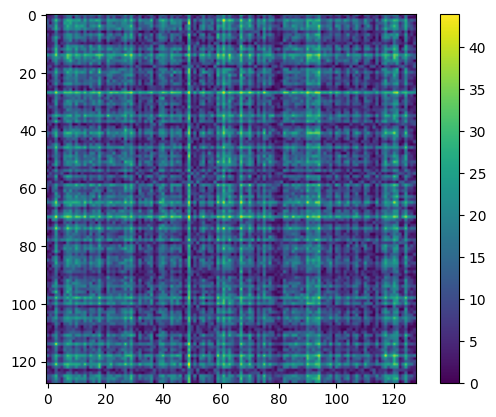

In [41]:
out = compute_block_wise_and_compare(
    expected= X@A.t()@B.t(),
    fn      = lambda out_block, idb, idm: test_batched_double_matmul[(1,)](out_block, X,A,B , bsb, bsm, bsn, bsr, idb, idm, n,r),
    dims    = (b,m), step_szs= (bsb, bsm),
    do_plot_err=True,
    do_return=True
)

Verify abs error distribution is exponentially distributed:

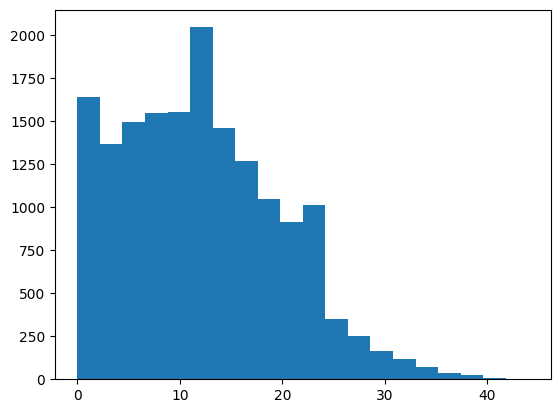

In [42]:
err = out - X@A.t()@B.t()
plt.hist(err.abs().flatten().cpu(), bins=20);

### Sub-Kernel 6: colnorm

In [43]:
# input:
# - w[m-chunk,:]
# - a[:,:]
# - b[m-chunk,:]
# output: col_norm[m-chunk]

In [44]:
@triton.jit
def col_norm(
    w_ptr, a_ptr, b_ptr,                # pointers
    bsm: const, bsn: const, bsr: const, # block sizes
    idm,                                # block indices
    n, r                                # matrix sizes
):
    # 1d offets along m,n,r axes
    offs_m = tu.offset_1d(bsm, idm)
    offs_n = tu.offset_1d(bsn, 0)
    offs_r = tu.offset_1d(bsr, 0)
    # 2d offsets of x,a,b
    offs_w = w_ptr + tu.offset_2d(offs_m, offs_n, n)
    # initialize and iteratively update accumulator for colnorm, using a regular matmul to compute b@a
    acc_colnorm = tl.zeros((bsm,bsn), dtype=tl.float32)  # accumulator for colnorm
    for idb in range(0, n, bsn):
        acc_mm = tl.zeros((bsm, bsn), dtype=tl.float32) # initialize accumulator for matmul
        # initialize / reset offsets for a & b
        offs_a = a_ptr + tu.offset_2d(offs_r, offs_n, n)
        offs_b = b_ptr + tu.offset_2d(offs_m, offs_r, r)        
        for idr in range(0, r, bsr):
            a = tl.load(offs_a)
            b = tl.load(offs_b)
            acc_mm += tl.dot(b, a, allow_tf32=False) # allow_tf32 must be set to False for older GPUs, otherwise won't compile
            # increase offsets, so next iteration loads next chunks
            offs_a += bsr*n # advance a by bsr rows
            offs_b += bsr   # advance b by bsr cols
        w = tl.load(offs_w)
        # update accumulator for colnorm
        acc_colnorm += (acc_mm+w)*(acc_mm+w)
    return tl.sqrt(tl.sum(acc_colnorm, axis=1))

In [45]:
@triton.jit
def test_col_norm(
    out_ptr,
    w_ptr, a_ptr, b_ptr,                # pointers
    bsm: const, bsn: const, bsr: const, # block sizes
    idm,                                # block indices
    n, r                                # matrix sizes
):
    out = col_norm(w_ptr, a_ptr, b_ptr, bsm, bsn, bsr, idm, n, r)
    tu.store_full_1d(out, out_ptr, bsm)

Test it with small 1-matrices

In [46]:
m,n,r       = 16,16,16
bsm,bsn,bsr = 16,16,16 # tl.dot requires all axes to be >= 16

# capitalize due to name conflict for b
W = ones(m,n)
A = ones(r,n)
B = ones(m,r)

compute_block_wise_and_compare(
    expected= ((W+B@A)**2).sum(axis=1).sqrt(),
    fn      = lambda out_block, idm: test_col_norm[(1,)](out_block, W,A,B ,  bsm, bsn, bsr, idm, n,r),
    dims=(m,), step_szs=(bsm,), do_print=True
)

output: tensor([68., 68., 68., 68., 68., 68., 68., 68., 68., 68., 68., 68., 68., 68., 68., 68.], device='cuda:0', dtype=torch.float16)
expected: tensor([68., 68., 68., 68., 68., 68., 68., 68., 68., 68., 68., 68., 68., 68., 68., 68.], device='cuda:0', dtype=torch.float16)
Equal ✅


Test it with large 1-matrices

In [47]:
m,n,r       = 128,128,128
bsm,bsn,bsr =  32, 16, 16 # tl.dot requires all axes to be >= 16

# capitalize due to name conflict for b
W = ones(m,n) * 0.01 # make small, due prevent overflow
A = ones(r,n) * 0.1
B = ones(m,r) * 0.1

out = compute_block_wise_and_compare(
    expected= ((W+B@A)**2).sum(axis=1).sqrt(),
    fn      = lambda out_block, idm: test_col_norm[(1,)](out_block, W,A,B ,  bsm, bsn, bsr, idm, n,r),
    dims=(m,), step_szs=(bsm,), atol=1e-3
)

Equal ✅


Test it with small random matrices

In [48]:
m,n,r       =  32, 32, 32
bsm,bsn,bsr =  16, 16, 16 # tl.dot requires all axes to be >= 16

# capitalize due to name conflict for b
W = rand(m,n) * 0.01 # make small, due prevent overflow
A = rand(r,n) * 0.1
B = rand(m,r) * 0.1

In [49]:
out = compute_block_wise_and_compare(
    expected= ((W+B@A)**2).sum(axis=1).sqrt(),
    fn      = lambda out_block, idm: test_col_norm[(1,)](out_block, W,A,B ,  bsm, bsn, bsr, idm, n,r),
    dims=(m,), step_szs=(bsm,), atol=0.15
)

Equal ✅


### Sub-Kernel 7: `* α, mag, 1/colnorm`

In [50]:
# input: y, alpha, mag, colnorm
# output: y*alpha*mag/colnorm

In [51]:
@triton.jit
def pointwise_mul(y, mag_ptr, colnorm, α, bsm: const, idm, m):
    mag = tu.load_1d(mag_ptr, bsm, idm, m)
    return α * y * mag[None,:] / colnorm[None,:]

In [52]:
@triton.jit
def test_pointwise_mul(out_ptr, y_ptr, mag_ptr, colnorm_ptr, α, bsb: const, bsm: const, idb, idm, b, m):
    y       = tu.load_2d(y_ptr, bsb, bsm, idb, idm, b, m, m)
    colnorm = tu.load_1d(colnorm_ptr, bsm, idm, m)    
    out = pointwise_mul(y, mag_ptr, colnorm, α, bsm, idm, m)
    tu.store_full_2d(out, out_ptr, bsb, bsm, bsm)

Test it with small 1-matrices

In [53]:
b,m     = 16,16
bsb,bsm = 16,16 # tl.dot requires all axes to be >= 16

α       = 2 
y       = ones(b,m)
colnorm = ones(m)
mag     = ones(m)

compute_block_wise_and_compare(
    expected= y*mag[None,:]/colnorm[None,:]*α,
    fn      = lambda out_block, idb, idm: test_pointwise_mul[(1,)](out_block, y, mag, colnorm, α, bsb, bsm, idb, idm, b, m),
    dims=(b,m), step_szs=(bsb,bsm)
)

Equal ✅


Test it with large 1-matrices

In [54]:
b,m     = 128, 128
bsb,bsm =  32,  32 # tl.dot requires all axes to be >= 16

α       = 2 
y       = ones(b,m)
colnorm = ones(m)
mag     = ones(m)

compute_block_wise_and_compare(
    expected= y*mag[None,:]/colnorm[None,:]*α,
    fn      = lambda out_block, idb, idm: test_pointwise_mul[(1,)](out_block, y, mag, colnorm, α, bsb, bsm, idb, idm, b, m),
    dims=(b,m), step_szs=(bsb,bsm)
)

Equal ✅


Test it with small random matrices

In [55]:
b,m     = 32, 32
bsb,bsm = 16, 32 # tl.dot requires all axes to be >= 16

α       = 2
y       = rand_3bit(b,m)
colnorm = rand_3bit(m) + 1 # add 1 to prevent dividing by 0
mag     = rand_3bit(m)

In [56]:
compute_block_wise_and_compare(
    expected= y*mag[None,:]/colnorm[None,:]*α,
    fn      = lambda out_block, idb, idm: test_pointwise_mul[(1,)](out_block, y, mag, colnorm, α, bsb, bsm, idb, idm, b, m),
    dims=(b,m), step_szs=(bsb,bsm)
)

Equal ✅


### Full Kernel

In [107]:
bp_kernel = '=100,=1' # activate breakpoint for which pids? Set to eg =100 to disable breakpoint.

@triton.jit
def forward_kernel(    
    X_ptr, A_ptr, B_ptr, W_qp_ptr, scale_q_ptr, zero_q_ptr,       # input matrices
    magnitude_ptr, sscale_ptr, szero_ptr, zscale_ptr, zzero_ptr,  # input vectors
    α,                                                            # input scalars
    Y_ptr,                                                        # output matrix
    b: const, m: const, r: const, n: const,                       # dimensions
    gz: const, gz2: const, pz: const,                             # grouping / packing configs
    bsb: const, bsm: const, bsr: const, bsn: const,               # block sizes
    # todo umer: add?                                             # strides
    W_tmp_ptr, # todo umer: should not need this                  # intermediate matrices
):
    tl.static_assert(n%gz==0, f'group_size ({gz}) must divide n ({n})')
    
    idb, idm = tl.program_id(0), tl.program_id(1) # block ids correspond to chunking of b and m axes

    ng:  const  = cdiv(m*n, gz)  # number of groups
    ng2: const  = cdiv(ng,  gz2) # number of groups for quanting zero/scale
    tl.static_assert(ng%gz2==0, f'num_groups ({ng}) needs to divide group_size_2 ({gz2}) for quanting of zero & scale to work')

    # (1) dequant zero & scale
    zero  = dequant_zero_or_scale(zero_q_ptr,  zzero_ptr, sscale_ptr, gz2, ng2, m, bsm, idm)
    scale = dequant_zero_or_scale(scale_q_ptr, szero_ptr, sscale_ptr, gz2, ng2, m, bsm, idm)    
    breakpoint_if(bp_kernel)
    
    # (2) unpack w
    W_q = load_W_q(W_qp_ptr, bsm, idm, m, n, gz, pz)
    breakpoint_if(bp_kernel)
    
    # (3) dequant w
    W = dequant_W(W_q, zero, scale, bsm, n)
    tu.store_full_2d(W, W_tmp_ptr, bsm, n, n) # todo umer: Remove intermediate storage in global mem
    breakpoint_if(bp_kernel)
    
    # (4) x@w.t
    XW = batched_matmul(X_ptr, W_tmp_ptr, bsb, bsm, bsn, idb, 0, b, n) # set idm=0, because W is already an m-chunk
    breakpoint_if(bp_kernel)

    # (5) x@a.t@b.t
    XAB = batched_double_matmul(X_ptr, A_ptr, B_ptr, bsb, bsm, bsn, bsr, idb, idm, n, r)    
    breakpoint_if(bp_kernel)

    # (6) colnorm
    colnorm = col_norm(W_tmp_ptr, A_ptr, B_ptr, bsm, bsn, bsr, 0, n, r) # set idm=0, because W is already an m-chunk
    breakpoint_if(bp_kernel)
    
    # (7) * α, mag, 1/colnorm    
    Y = pointwise_mul(XW + XAB, magnitude_ptr, colnorm, α, bsm, idm, m)
    breakpoint_if(bp_kernel)
    
    # store
    tu.store_2d(Y, Y_ptr, bsb, bsm, idb, idm, b, m, m)
    breakpoint_if(bp_kernel)

In [108]:
b,m,r,n = 16,32,32,32 # batch size, out, lora rank, in
gz,gz2  = 16,16       # group size, group size for quanting zero & scale, pack size

ng  = cdiv(m*n, gz) # number of groups
ng2 = cdiv(ng , gz2)# number of groups for quanting zero/scale

print(f'{ng = }, {ng2 = }')
assert n%gz==0, f'group_size ({gz}) needs to divide n ({n})'
print(f'group_size ({gz}) divides n ({n}) ✓')
assert ng%gz2==0, f'num_groups ({ng}) needs to divide group_size_2 ({gz2}) for quanting of zero & scale to work'
print(f'num_groups ({ng}) divides group_size_2 ({gz2}) ✓')

ng = 64, ng2 = 4
group_size (16) divides n (32) ✓
num_groups (64) divides group_size_2 (16) ✓


In [109]:
# for simplicity, choose zeros & scales so that dequanting doesn't change values (ie zero=0, scale=1)
scale_q, zero_q = ones(gz2, ng2), zeros(gz2, ng2)
sscale, szero, zscale, zzero = ones(1, ng2), zeros(1, ng2), ones(1, ng2), zeros(1, ng2)

# set all matrices/vectors/scalars to 1
X, A, B = ones(b,n), ones(r,n), ones(m,r)
mag = ones(m)
α = 1

W_q = ones(ng, gz)
W_qp = BitPack.pack_3bit_32(W_q)

In [110]:
def fwd_op(fwd_k, bsb, bsm, bsr, bsn):
    # for simplicity, following vars are used from closure (in actual op, they'll be passed):
    #   X, A, B, W_qp, scale_q, zero_q,
    #   mag, sscale, szero, zscale, zzero
    #   α
    # for simplicity, following vars are used from closure (in actual op, they'll be read from input vars)
    #   b,m,r,n
    Y = zeros(b,m)
    W_tmp = zeros(bsm,n)
    tu.assert_tensors_gpu_ready(Y, X, A, B, W_qp, mag, scale_q, zero_q, sscale, szero, zscale, zzero, W_tmp)
    grid = (cdiv(b, bsb), cdiv(m, bsm))
    print(f'Launching grid of size {grid}')
    fwd_k[grid](
        X, A, B, W_qp, scale_q, zero_q,  # input matrices
        mag, sscale, szero, zscale, zzero, # input vectors
        α, # input scalars
        Y, # output matrix
        b,m,r,n,# dimensions
        gz, gz2, pz, # grouping / packing configs
        bsb, bsm, bsr, bsn, # block sizes
        # todo umer: add? # strides
        W_tmp, # todo umer: should not need this # intermediate matrices
    )
    return Y

In [111]:
block_sizes = dict(bsb=16, bsm=16, bsr=16, bsn=16)
out = fwd_op(forward_kernel, **block_sizes)

Launching grid of size (1, 2)


In [112]:
# # for reference while debugging
# b,m,r,n = 16,32,32,32 # batch size, out, lora rank, in
# gz,gz2  = 16,16       # group size, group size for quanting zero & scale, pack size
# bsb, bsm, bsn = 16, 16, 16
# n//gz = 2
from math import sqrt
from tabulate import tabulate
def expected_sizes(b, m, r, n, gz, gz2, pz, bsb, bsm, bsr, bsn):
    print('assuming ever input == 1 (except zeros), then:')
    print(tabulate([
        ['zero', 'bsm*n//gz', f'{bsm*n//gz}', '0', '0'],
        ['scale', 'bsm*n//gz', f'{bsm*n//gz}', '1', '1'],
        ['W_q', 'bsm*n//gz, gz', f'{bsm*n//gz}, {gz}', '1', '1'],
        ['W', 'bsm, n', f'{bsm}, {n}', '1', '1'],
        ['XW', 'bsb, bsm', f'{bsb}, {bsm}', 'n', f'{n}'],
        ['XAB', 'bsb, bsm', f'{bsb}, {bsm}', 'n*r', f'{n*r}'],
        ['colnorm', 'bsm', f'{bsm}', 'sqrt(n(1+r)**2)', f'{sqrt(n*(1+r)**2):.0f}'],
        ['Y', 'bsb, bsm', f'{bsb}, {bsm}', '(n+nr)/sqrt(n(1+r)**2)', f'{(n+n*r)/sqrt(n*(1+r)**2):.0f}']
    ], headers=['Variable', 'Shape Formula', 'Shape', 'Value Formula', 'Value']))
expected_sizes(b, m, r, n, gz, gz2, pz, **block_sizes)

assuming ever input == 1 (except zeros), then:
Variable    Shape Formula    Shape    Value Formula             Value
----------  ---------------  -------  ----------------------  -------
zero        bsm*n//gz        32       0                             0
scale       bsm*n//gz        32       1                             1
W_q         bsm*n//gz, gz    32, 16   1                             1
W           bsm, n           16, 32   1                             1
XW          bsb, bsm         16, 16   n                            32
XAB         bsb, bsm         16, 16   n*r                        1024
colnorm     bsm              16       sqrt(n(1+r)**2)             187
Y           bsb, bsm         16, 16   (n+nr)/sqrt(n(1+r)**2)        6


In [124]:
assert_close(
    out,
    α*mag*X@(W+B@A).t()/((W+B@A)**2).sum(axis=1).sqrt(),
    do_print=True
)

output: tensor([[5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66],
        [5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66],
        [5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66],
        [5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66],
        [5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5.66, 5